# Deep VQE
https://arxiv.org/abs/2007.10917

In [1]:
from qulacs import Observable
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import RX, RZ, RY, CNOT, X, Y, Z, CZ
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

# ハミルトニアン (N=2)

![hamiltonian(3a,N=2)](./Figures/3a_N2.png)

\begin{align}
\mathcal{H} = \sum^{1}_{i=0}\mathcal{H}_i + \sum_{(i, j)=(2, 4), (0, 6)}V_{ij}
\end{align}

\begin{align}
\mathcal{H}_i &= \sum_{(j, k) \in E}\sum_{A=X,Y,Z}A_{j}A_{k} \\
V_{ij} &= \sum_{A=X,Y,Z}A_{i}A_{j}
\end{align}

上の図で黒い線で繋がった格子が部分系$\mathcal{H}_i$で赤い線が相互作用$V_{ij}$をそれぞれ表している。  
対称性より$\mathcal{H}_i$の基底状態の計算はどちらか片方だけを行えば良い。  

局所基底には
\begin{align}
\def\ket#1{\mathinner{\left|{#1}\right\rangle}}
\ket{\psi^{(i)}_0}, A^{(i)}_0\ket{\psi^{(i)}_0}, A^{(i)}_2\ket{\psi^{(i)}_0},
\end{align}
の全部で$K=7$を用いる。  
また$A^{(i)}_0$は部分系$i$で0番目の量子ビットを意味する。  

In [2]:
E = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]
hamiltonian = []
for (i, j) in E:
    for A in ["X", "Y", "Z"]:
        hamiltonian.append((1, "{} {} {} {}".format(A, i, A, j)))
print(hamiltonian)

[(1, 'X 0 X 1'), (1, 'Y 0 Y 1'), (1, 'Z 0 Z 1'), (1, 'X 1 X 2'), (1, 'Y 1 Y 2'), (1, 'Z 1 Z 2'), (1, 'X 2 X 3'), (1, 'Y 2 Y 3'), (1, 'Z 2 Z 3'), (1, 'X 3 X 0'), (1, 'Y 3 Y 0'), (1, 'Z 3 Z 0'), (1, 'X 0 X 2'), (1, 'Y 0 Y 2'), (1, 'Z 0 Z 2')]


## オブザーバブルの作成

In [3]:
n_bits = 4
observable = Observable(n_bits)
for (coef, Pauli_string) in  hamiltonian :
    observable.add_operator(coef, Pauli_string)

以下の関数は`https://dojo.qulacs.org/ja/latest/notebooks/6.2_qulacs_VQE.html`から引用している。

In [4]:
def cost(phi):
    state = QuantumState(n_bits)
    state.set_zero_state()
    circuit = make_ansatz_circuit(phi, n_bits, E)
    circuit.update_quantum_state(state)
    return observable.get_expectation_value(state)

In [5]:
def callback(phi):
    global cost_val
    cost_val.append(cost(phi))

In [6]:
d = 5
def make_ansatz_circuit(phi, n_bits, E, d=d):
    circuit = QuantumCircuit(n_bits)
    param_count = 0
    for _ in range(d):
        for n in range(n_bits):
            circuit.add_gate(RX(n, phi[param_count]))
            circuit.add_gate(RY(n, phi[param_count+1]))
            circuit.add_gate(RZ(n, phi[param_count+2]))
            param_count += 3
        for i in range(n_bits//2):
                circuit.add_gate(CZ(2*i, 2*i+1))
                #circuit.add_gate(CNOT(2*i+1, 2*i+2))
        for i in range(n_bits//2-1):
                circuit.add_gate(CZ(2*i+1, 2*i+2))
                #circuit.add_gate(CNOT(2*i+1, 2*i+2))
    for n in range(n_bits):
        circuit.add_gate(RX(n, phi[param_count]))
        circuit.add_gate(RY(n, phi[param_count+1]))
        circuit.add_gate(RZ(n, phi[param_count+2]))
    return circuit

In [7]:
from qulacs import ParametricQuantumCircuit
from qulacs.gate import Pauli

In [8]:
d = 1
def make_ansatz_circuit(phi, n_bits, E, d=d):
    circuit = ParametricQuantumCircuit(n_bits)
    for _ in range(3):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                gate = Pauli(target_list, pauli_index)
                circuit.add_gate(gate)
    param_count = 0
    for _ in range(d):
        for (i, j) in E:
            target_list = [i, j]
            for k in range(1, 4):
                pauli_index = [k, k]
                circuit.add_parametric_multi_Pauli_rotation_gate(target_list, pauli_index, phi[param_count])
                param_count += 1
            circuit.add_gate(RX(i, phi[param_count]))
            circuit.add_gate(RX(j, phi[param_count+1]))
            circuit.add_gate(RZ(i, phi[param_count+2]))
            circuit.add_gate(RZ(j, phi[param_count+3]))
            param_count += 4
        for i in range(n_bits//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
        for i in range(n_bits//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
            #circuit.add_gate(CNOT(2*i+1, 2*i+2))
    return circuit

## 最適化の実行
最適化された変分回路のパラメータは`phi_opt`に格納されている。

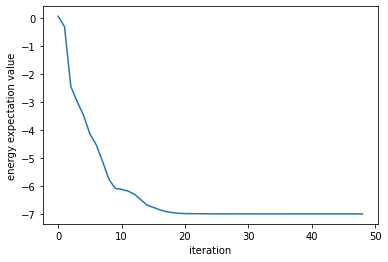

time:0.9062285423278809
VQE Energy: -6.999999999973239


In [9]:
n_params = len(E)*(3+4)*(d)
np.random.seed(1111)
phi = np.random.random(n_params)*2.0*np.pi
#print(phi)
cost_val = []
callback(phi)
start = time.time()
#res = minimize(cost, phi, method='Powell', callback=callback)
res = minimize(cost, phi, method='BFGS', callback=callback)
end = time.time()

plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

phi_opt = res.x
print("time:{}".format(end-start))
print("VQE Energy: {}".format(cost(phi_opt)))

# 有効ハミルトニアンの作成

有効ハミルトニアンを得るには次の演算子
\begin{align}
W^{(i)}_k\;\dagger W^{(i)}_l\;, \;\;\; W^{(i)}_k\;\dagger \mathcal{H}^{(i)}W^{(i)}_l, \;\;\; W^{(i)}_k\;\dagger W^{(i)}_{\mu} W^{(i)}_l
\end{align}
の$|\psi^{(i)}_0>$での期待値を計算する必要がある。

## WW, WHW, WVWの計算

In [10]:
K = 7
n_bits = 4
W = ['I 0', 'X 0', 'Y 0', 'Z 0', 'X 2', 'Y 2', 'Z 2']
V = ['X 0', 'Y 0', 'Z 0', 'X 2', 'Y 2', 'Z 2']
WW = np.zeros((K, K))
WHW = np.zeros((K, K))
WVW = np.zeros((K-1, K, K))

# 部分系のハミルトニアンの基底状態を作り出す。
state = QuantumState(n_bits)
state.set_zero_state()
circuit = make_ansatz_circuit(phi_opt, n_bits, E)
circuit.update_quantum_state(state)

for i in range(K):
    for j in range(K):
        # WW
        Pauli_string = W[i] + " " + W[j]
        obs = Observable(n_bits)
        obs.add_operator(1, Pauli_string)
        if obs.is_hermitian() != True:
                print((i, j), obs.is_hermitian())
        WW[i][j] = obs.get_expectation_value(state)
        
        # WHW
        obs = Observable(n_bits)
        for (coeff, op) in hamiltonian:
            Pauli_string = W[i] + " " +  op + " " + W[j]
            obs.add_operator(coeff, Pauli_string)
        if obs.is_hermitian() != True:
                print((i, j), obs.is_hermitian())
        WHW[i][j] = obs.get_expectation_value(state)
        
        # WVW
        for k in range(K-1):
            Pauli_string = W[i] + " " + V[k] + " " + W[j]
            obs = Observable(n_bits)
            obs.add_operator(1, Pauli_string)
            if obs.is_hermitian() != True:
                print((i, j, k), obs.is_hermitian())
            WVW[k][i][j] = obs.get_expectation_value(state)

## Pの計算
Pの各成分に$|\psi^{(i)}_k>$の係数が格納されている。

In [11]:
P = np.zeros((K, K))
for i in range(K):
    P[i][i] = 1.0
    for j in range(i):
        coeff = 0
        for k in range(K):
            coeff += P[j][k] * WW[k][i]
        #print(i, j, coeff, P[j])
        P[i] -= coeff * P[j]
    C = 0
    for k in range(K):
        for l in range(K):
            C += P[i][k] * P[i][l] * WW[k][l]
    P[i] *= 1.0/np.sqrt(C)

正規直行化されていることの確認

In [12]:
norm = np.zeros((K, K))
for k in range(K):
    for l in range(K):
        n = 0
        for i in range(K):
            for j in range(K):
                n += P[k][i] * P[l][j] * WW[i][j]
        if abs(n) <= 1e-10:
            n = 0
        norm[k][l] = n
print(norm)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]


## 新しい局所基底(正規直交基底)と量子ビットを対応させる。  
各部分系に対して3量子ビットずつ準備する。

In [13]:
K = 7
n_bits_new = int(np.ceil(np.log2(K)))
psi = {}
print("Subsystem 0")
for i in range(K):
    psi[i] = format(i, '0{}b'.format(n_bits_new))
    print(i, format(i, '0{}b'.format(n_bits_new)))
print("Subsystem 1")
for i in range(K):
    psi[i+K] = format(i, '0{}b'.format(n_bits_new))
    print(i+K, format(i, '0{}b'.format(n_bits_new)))
#print(psi)

Subsystem 0
0 000
1 001
2 010
3 011
4 100
5 101
6 110
Subsystem 1
7 000
8 001
9 010
10 011
11 100
12 101
13 110


## 射影演算子と量子ゲートを対応させる。

In [14]:
def get_projection(i, j, bit, K, sub_idx):
    # | i >|< j | _{bit} 
    bit += int(np.ceil(np.log2(K))) * sub_idx
    op_list = []
    if (i, j) == (0, 0):
        op_list.append((0.5, 'I {}'.format(bit)))
        op_list.append((0.5, 'Z {}'.format(bit)))
    elif (i, j) == (1, 1):
        op_list.append((0.5, 'I {}'.format(bit)))
        op_list.append((-0.5, 'Z {}'.format(bit)))
    elif (i, j) == (0, 1):
        op_list.append((0.5, 'X {}'.format(bit)))
        op_list.append((-0.5, 'X {} Z {}'.format(bit, bit)))
    elif (i, j) == (1, 0):
        op_list.append((0.5, 'X {}'.format(bit)))
        op_list.append((0.5, 'X {} Z {}'.format(bit, bit)))
    return op_list

In [15]:
def get_local_basis_operator(psi1, psi2, K, sub_idx=0):
    bit_num = int(np.ceil(np.log2(K)))
    op_list = []
    for i in range(bit_num):
        op_list_temp = get_projection(int(psi1[i]), int(psi2[i]), i, K, sub_idx)
        op_list.append(op_list_temp)
    res = []
    for i in range(2):
        for j in range(2):
            for k in range(2):
                coeff = op_list[0][i][0] * op_list[1][j][0] * op_list[2][k][0]
                op = op_list[0][i][1] + " " +  op_list[1][j][1] + " " +  op_list[2][k][1]
                res.append((coeff, op))
    return res

# 有効ハミルトニアンの作成

## 部分系の有効ハミルトニアン

In [16]:
def make_H_eff_i(WHW, P, K, num_sub=2):
    H_eff_i = np.dot(P, np.dot(WHW, P.T))
    H_eff_i_list = []
    for sub_idx in range(num_sub):
        for k in range(K):
            for l in range(K):
                op_list = get_local_basis_operator(psi[k], psi[l], K, sub_idx)
                for (coeff, op) in op_list:
                    H_eff_i_list.append((H_eff_i[k][l]*coeff, op))
    return H_eff_i_list

In [17]:
H_eff_i_list = make_H_eff_i(WHW, P, K, 2)

In [18]:
len(H_eff_i_list)

784

## 相互作用の有効ハミルトニアン

In [19]:
def make_V_eff(WVW, P, K):
    WVW_ = np.zeros((K-1, K, K))
    for k in range(K-1):
        WVW_[k] = np.dot(P, np.dot(WVW[k], P.T))
    V_eff_list = []
    V_eff = np.zeros((K, K, K, K))
    for i in range(K):
        for j in range(K):
            op_list1 = get_local_basis_operator(psi[i], psi[j], K, 0)
            for k in range(K):
                for l in range(K):
                    op_list2 = get_local_basis_operator(psi[k+K], psi[l+K], K, 1)
                    coeff = 0
                    for m in range(K//2):
                        coeff += WVW_[m][i][j] * WVW_[m+K//2][k][l]
                        #coeff += WVW_[m+K//2][i][j] * WVW_[m][k][l]
                    for (coeff1, op1) in op_list1:
                        for (coeff2, op2) in op_list2:
                            coeff_ = coeff*coeff1*coeff2
                            if abs(coeff_) > 1e-3:
                                op = op1 + " " + op2
                                V_eff_list.append((coeff*coeff1*coeff2, op))
                    V_eff[i][j][k][l] = coeff
        return V_eff_list, WVW_, V_eff

In [20]:
V_eff_list, WVW_, V_eff = make_V_eff(WVW, P, K)

In [21]:
len(V_eff_list)

3072

## オブザーバブルの定義

In [22]:
n_bits = int(np.ceil(np.log2(K))) * 2
observable = Observable(n_bits)
for (coef, Pauli_string) in  H_eff_i_list:
    observable.add_operator(coef, Pauli_string)
for (coef, Pauli_string) in  V_eff_list:
    observable.add_operator(coef, Pauli_string)

In [23]:
def cost(phi):
    state = QuantumState(n_bits)
    state.set_zero_state()
    circuit = make_ansatz_circuit(phi, n_bits, E)
    circuit.update_quantum_state(state)
    return observable.get_expectation_value(state)

In [24]:
d = 5
def make_ansatz_circuit(phi, n_bits, E, d=d):
    circuit = QuantumCircuit(n_bits)
    param_count = 0
    for _ in range(d):
        for n in range(n_bits):
            circuit.add_gate(RX(n, phi[param_count]))
            circuit.add_gate(RY(n, phi[param_count+1]))
            circuit.add_gate(RZ(n, phi[param_count+2]))
            param_count += 3
        for i in range(n_bits//2):
                circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_bits//2-1):
                circuit.add_gate(CZ(2*i+1, 2*i+2))
    for n in range(n_bits):
        circuit.add_gate(RX(n, phi[param_count]))
        circuit.add_gate(RY(n, phi[param_count+1]))
        circuit.add_gate(RZ(n, phi[param_count+2]))
    return circuit

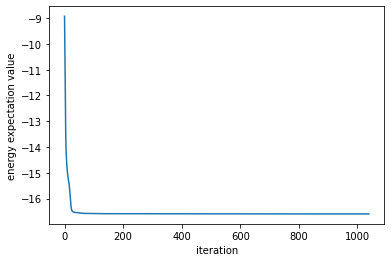

Time:2831.7456245422363
VQE Energy: -16.59217802288835


In [30]:
n_params = n_bits*3*(d+1)
np.random.seed(1111)
cost_val = []
phi = np.random.random(n_params)*2.0*np.pi
#print(phi)
callback(phi)
start = time.time()
#res = minimize(cost, phi, method='Powell', callback=callback)
res = minimize(cost, phi, method='BFGS', callback=callback)
end = time.time()

plt.plot(cost_val)
plt.xlabel("iteration")
plt.ylabel("energy expectation value")
plt.show()

phi_opt = res.x
print("Time:{}".format(end-start))
print("VQE Energy: {}".format(cost(phi_opt)))

# 行列要素の検算
有効ハミルトニアンと相互作用のハミルトニアンを合わせた行列要素を作り対角化することでVQEを使わなかった場合と検算する。

In [25]:
local_basis = [(i, j) for i in range(K) for j in range(K)]
H_eff_i = np.dot(P, np.dot(WHW, P.T))
H_eff = np.zeros((K*K, K*K))
for i in range(K*K):
    for j in range(K*K):
        (k, l) = local_basis[i]
        (m, n) = local_basis[j]
        delta1 = (k==m)
        delta2 = (l==n)
        H_eff[i, j] = H_eff_i[k, m]*delta2 + H_eff_i[l, n]*delta1  + V_eff[k][m][l][n]

In [26]:
np.min(np.linalg.eig(H_eff)[0])

(-16.477247875270518+0j)

厳密解(14.46)と一致していないのでどこかで計算ミスが生じている。  
`WHW`と`WVW`が怪しい。